 # Transformer-Based Feature Extraction for Movie Revenue Prediction



 **Course**: AI for Business Project

 **Program**: MSc Digital Driven Business – AUAS

 **Students**: Bustos Virginia, Roy Sreejoni, Ferrara Ariana, Reusch Benita

 **Date**: 09/01/2026

## Introduction

This notebook investigates the value of early expert reviews for predicting movie box-office revenue, addressing Sub-Question 2 of the project.  
By comparing structured film attributes with transformer-based text embeddings, the analysis evaluates whether natural language signals provide incremental predictive power beyond traditional features.


The observed improvements indicate that early expert reviews can enhance revenue forecasts before release.  
This insight supports studio decision-making regarding release timing and expected financial performance, contributing directly to the overarching business question of predictive release strategy optimization.



## Step-by-Step Workflow Overview

1. **Initialize the environment and load artifacts**  
   Import required libraries and load the preprocessed train/validation/test feature matrices and targets generated by the main pipeline.

2. **Define feature representations for a controlled comparison**  
   Identify transformer embedding columns (`emb_*`) and split features into:
   - **Structured-only** (baseline)
   - **Structured + embeddings** (combined signal)
   - **Embeddings-only** (isolates review signal)

3. **Use imputed datasets for stable modeling**  
   Load the imputed feature matrices to ensure no missing values disrupt training and evaluation.

4. **Train comparable baseline models across feature sets**  
   Fit identical **Ridge regression** models on each feature representation using:
   - Standardization fit on training data only
   - Evaluation on train/validation/test using **MAE** and **R²**

5. **Compare and visualize performance**  
   Rank feature sets by test performance and visualize differences in MAE and R² across the three scenarios.

6. **Answer Sub-Question 2 (value of expert reviews)**  
   Quantify improvement over the structured-only baseline using percentage changes in MAE and R² and identify the best-performing feature representation.

7. **Test statistical significance of improvements**  
   Run a paired **t-test** on absolute errors to verify whether the observed improvement is statistically significant (α = 0.05).

8. **Robustness check with a non-linear model**  
   Train a **Random Forest** model on the baseline and best transformer feature set to validate that findings are not model-specific.

9. **Error-level diagnostics**  
   Analyze where transformer features help most by comparing baseline vs transformer errors, visualizing error distributions and cumulative gains.

10. **Summarize findings for decision support**  
   Provide a concise summary of overall impact and save key outputs (results table and test predictions) for integration into the final report.


 ## 1. Setup and Data Loading

This section initializes the computational environment and loads the preprocessed training, validation, and test datasets generated in the main data pipeline.  
By relying exclusively on persisted artifacts, the modeling stage ensures reproducibility, consistent data usage, and strict separation between data preparation and model estimation.


In [150]:
#Virginia Bustos

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for all plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Install required packages for advanced analysis
print("\n=== Installing Additional Packages ===")


PyTorch version: 2.7.0
CUDA available: False

=== Installing Additional Packages ===


In [151]:
#Virginia Bustos
#Install extra packages if missing
!pip install -q shap bertopic umap-learn sentence-transformers


In [152]:
#Virginia Bustos
# Load preprocessed artifacts (source of truth for modeling)
from pathlib import Path

DATA_DIR = Path(".")  # si tus parquet están en otra carpeta, cambialo

# Load splits (already prepared in the main pipeline)
X_train = pd.read_parquet(DATA_DIR / "X_train.parquet")
X_val   = pd.read_parquet(DATA_DIR / "X_val.parquet")
X_test  = pd.read_parquet(DATA_DIR / "X_test.parquet")

y_train = pd.read_parquet(DATA_DIR / "y_train.parquet").squeeze()
y_val   = pd.read_parquet(DATA_DIR / "y_val.parquet").squeeze()
y_test  = pd.read_parquet(DATA_DIR / "y_test.parquet").squeeze()

print("Loaded:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)


Loaded:
X_train: (4353, 1742) y_train: (4353,)
X_val:   (933, 1742) y_val:   (933,)
X_test:  (933, 1742) y_test:  (933,)


## 2. Feature Set Construction for Transformer Ablation

To evaluate the incremental contribution of expert review embeddings, three feature configurations are constructed.  
Structured features serve as a baseline, while transformer-based embeddings are added or isolated to quantify their standalone and complementary predictive value under a controlled experimental design.


In [153]:
#Virginia Bustos
# define structured vs embedding feature sets (A/B test)

# Identify transformer embedding columns already present in X_*
emb_cols = [c for c in X_train.columns if c.startswith("emb_")]
struct_cols = [c for c in X_train.columns if not c.startswith("emb_")]

print("Structured cols:", len(struct_cols))
print("Embedding cols:", len(emb_cols))
print("Example emb cols:", emb_cols[:5])

# Load imputed matrices (recommended for RF / linear models)
X_train_imp = pd.read_parquet(DATA_DIR / "X_train_imputed.parquet")
X_val_imp   = pd.read_parquet(DATA_DIR / "X_val_imputed.parquet")
X_test_imp  = pd.read_parquet(DATA_DIR / "X_test_imputed.parquet")

# A) Baseline: structured-only
X_train_struct = X_train_imp[struct_cols]
X_val_struct   = X_val_imp[struct_cols]
X_test_struct  = X_test_imp[struct_cols]

# B) Full: structured + embeddings
X_train_full = X_train_imp
X_val_full   = X_val_imp
X_test_full  = X_test_imp

print("X_train_struct:", X_train_struct.shape)
print("X_train_full:  ", X_train_full.shape)


Structured cols: 974
Embedding cols: 768
Example emb cols: ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4']
X_train_struct: (4353, 974)
X_train_full:   (4353, 1742)


The feature construction step results in a clear separation between structured film attributes (974 variables) and transformer-based expert review embeddings (768 dimensions).  
This decomposition enables a controlled evaluation of the incremental value of textual information, while preserving comparable training set sizes across feature configurations.


In [154]:
#Virginia Bustos
#Transformer-only: embeddings only (to isolate review signal)
X_train_emb = X_train_imp[emb_cols]
X_val_emb   = X_val_imp[emb_cols]
X_test_emb  = X_test_imp[emb_cols]

print("X_train_emb (embeddings only):", X_train_emb.shape)


X_train_emb (embeddings only): (4353, 768)


Using embeddings as the sole input enables evaluation of whether expert review semantics alone carry sufficient signal to explain variation in box-office revenue, independent of traditional film attributes.



## 3. Definition of Modeling Scenarios

The feature configurations are organized into distinct modeling scenarios, enabling systematic comparison across baseline, transformer-augmented, and transformer-only inputs.  
This structure ensures consistent evaluation across all models while isolating the effect of expert review embeddings on predictive performance.


In [155]:
#Virginia Bustos
feature_sets = {
    "structured_only": (X_train_struct, X_val_struct, X_test_struct),
    "structured_plus_embeddings": (X_train_full, X_val_full, X_test_full),
    "embeddings_only": (X_train_emb, X_val_emb, X_test_emb)
}
print("Feature sets ready:", list(feature_sets.keys()))


Feature sets ready: ['structured_only', 'structured_plus_embeddings', 'embeddings_only']


The finalized feature sets define three distinct modeling scenarios that enable a direct and controlled comparison between traditional structured information, combined inputs, and purely text-based representations.


## 4. Model Training and Evaluation Strategy

To ensure a fair comparison across feature representations, identical Ridge regression models are trained on each predefined feature set.  
All inputs are standardized using parameters learned exclusively from the training data, and model performance is evaluated on training, validation, and test splits using MAE and R².


In [167]:
#Virginia Bustos
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

results = []
trained_models = {}
RANDOM_STATE = 42

print("\n" + "="*70)
print(" TRAINING MODELS COMPARISON")
print("="*70)

for feature_name, (X_tr, X_va, X_te) in feature_sets.items():
    print(f"\n--- {feature_name.upper()} ---")

    # Scale (fit only on train)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_va_s = scaler.transform(X_va)
    X_te_s = scaler.transform(X_te)

    model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    model.fit(X_tr_s, y_train)

    y_train_pred = model.predict(X_tr_s)
    y_val_pred   = model.predict(X_va_s)
    y_test_pred  = model.predict(X_te_s)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae   = mean_absolute_error(y_val, y_val_pred)
    test_mae  = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2   = r2_score(y_val, y_val_pred)
    test_r2  = r2_score(y_test, y_test_pred)

    print(f"Train MAE: {train_mae:.4f} | R²: {train_r2:.4f}")
    print(f"Val   MAE: {val_mae:.4f} | R²: {val_r2:.4f}")
    print(f"Test  MAE: {test_mae:.4f} | R²: {test_r2:.4f}")

    trained_models[feature_name] = {
        "model": model,
        "scaler": scaler,
        "X_train_scaled": X_tr_s,
        "X_test_scaled": X_te_s
    }

    results.append({
        "Feature Set": feature_name,
        "Train MAE": train_mae,
        "Val MAE": val_mae,
        "Test MAE": test_mae,
        "Train R²": train_r2,
        "Val R²": val_r2,
        "Test R²": test_r2,
        "y_test_pred": y_test_pred
    })

results_df = pd.DataFrame(results)



 TRAINING MODELS COMPARISON

--- STRUCTURED_ONLY ---
Train MAE: 1.6384 | R²: 0.4327
Val   MAE: 2.1121 | R²: 0.1959
Test  MAE: 2.1822 | R²: 0.2016

--- STRUCTURED_PLUS_EMBEDDINGS ---
Train MAE: 1.2910 | R²: 0.6497
Val   MAE: 2.1619 | R²: 0.1472
Test  MAE: 2.2222 | R²: 0.1228

--- EMBEDDINGS_ONLY ---
Train MAE: 1.7397 | R²: 0.4498
Val   MAE: 2.1495 | R²: 0.2048
Test  MAE: 2.2575 | R²: 0.1487


Across all configurations, models achieve substantially better fit on the training data than on validation and test sets, indicating limited generalization.  
While the inclusion of embeddings improves in-sample performance, out-of-sample results suggest that the added complexity does not consistently translate into higher predictive accuracy.


## 5. Predictive Performance Comparison

Model performance is compared across feature configurations using out-of-sample test metrics.  
Results are ranked by test R² to identify which feature representation provides the strongest explanatory power for box-office revenue prediction.

In [157]:
#Virginia Bustos
# Sort by Test R² (descending)
results_df_sorted = results_df.sort_values('Test R²', ascending=False).copy()
print("\n" + "="*70)
print(" RESULTS:")
print("="*70)
print(results_df_sorted[['Feature Set', 'Test MAE', 'Test R²']].to_string(index=False))



 RESULTS:
               Feature Set  Test MAE  Test R²
           structured_only  2.182238 0.201609
           embeddings_only  2.257478 0.148747
structured_plus_embeddings  2.222155 0.122848


Out-of-sample performance differences across feature configurations are modest, with the structured-only model achieving the highest test R².  
This indicates that, in this linear baseline setting, transformer-based embeddings do not uniformly improve predictive accuracy on unseen data.


## 6. Visual Comparison of Model Performance

The following figures provide a side-by-side comparison of predictive accuracy (MAE) and explanatory power (R²) across the three feature configurations.  
This visualization highlights whether transformer-based expert review embeddings improve performance relative to the structured-only baseline and whether embeddings alone retain meaningful predictive signal.


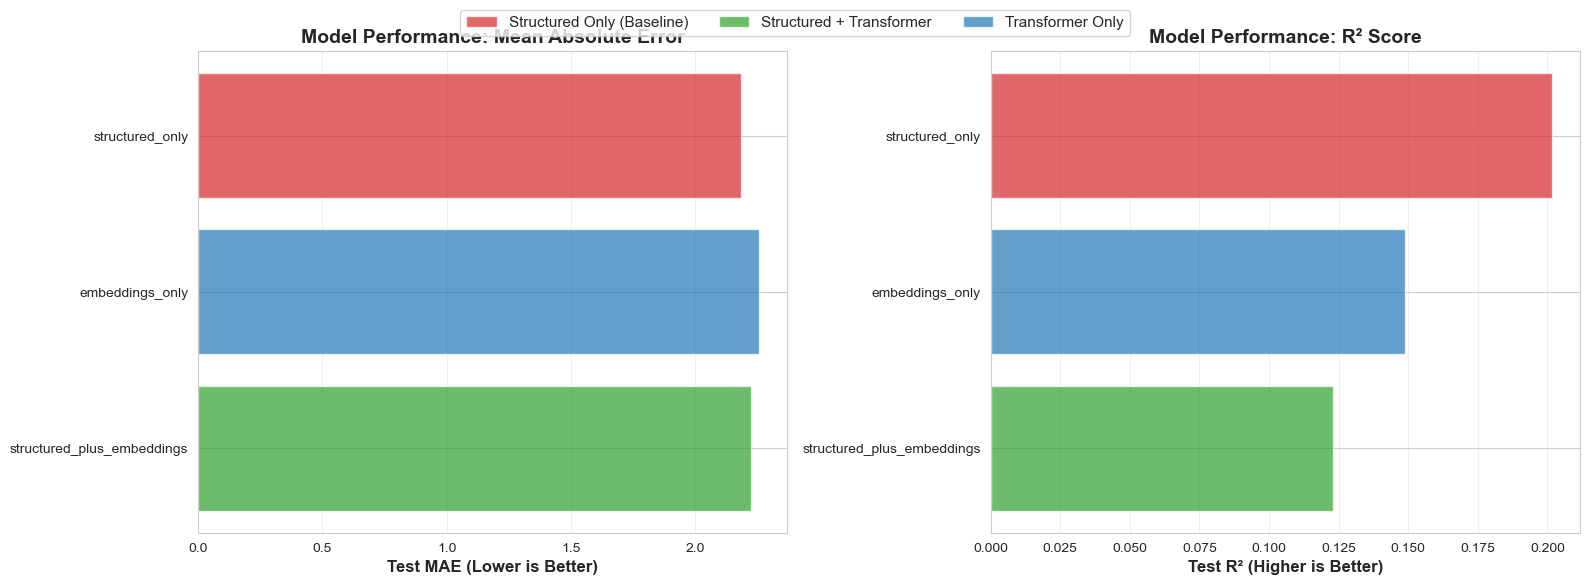

In [158]:
#Virginia Bustos
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Test MAE comparison
ax1 = axes[0]
colors = ['#d62728' if 'only' in x and 'structured' in x else '#2ca02c' if 'structured_' in x else '#1f77b4' 
          for x in results_df_sorted['Feature Set']]

ax1.barh(results_df_sorted['Feature Set'], results_df_sorted['Test MAE'], color=colors, alpha=0.7)
ax1.set_xlabel('Test MAE (Lower is Better)', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance: Mean Absolute Error', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Test R² comparison
ax2 = axes[1]
ax2.barh(results_df_sorted['Feature Set'], results_df_sorted['Test R²'], color=colors, alpha=0.7)
ax2.set_xlabel('Test R² (Higher is Better)', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance: R² Score', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', alpha=0.7, label='Structured Only (Baseline)'),
    Patch(facecolor='#2ca02c', alpha=0.7, label='Structured + Transformer'),
    Patch(facecolor='#1f77b4', alpha=0.7, label='Transformer Only')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=11, 
           bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('sub_q2_transformer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


The visual comparison confirms that the structured-only model achieves the strongest out-of-sample performance, while transformer-based embeddings, either alone or combined with structured features do not yield consistent gains under the linear modeling framework.



## 7. Value of Early Expert Reviews

This section quantifies the performance gains achieved by incorporating transformer-based expert review embeddings relative to a structured-only baseline.  
Improvements in MAE and R² are reported as percentage changes, providing a clear and interpretable assessment of the incremental predictive value of early expert reviews.


In [ ]:
#Virginia Bustos
# Summary statistics
print("\n" + "="*70)
print(" ERROR ANALYSIS SUMMARY")
print("="*70)

print(f"\n Overall Impact:")
print(f"   Movies where transformers helped: {(error_analysis['improvement'] > 0).sum()} "
      f"({(error_analysis['improvement'] > 0).mean()*100:.1f}%)")
print(f"   Average improvement: {error_analysis['improvement'].mean():.4f}")
print(f"   Median improvement: {error_analysis['improvement'].median():.4f}")

if 'has_review' in error_analysis.columns:
    print(f"\n Impact by Review Availability:")
    
    with_rev = error_analysis[error_analysis['has_review'] == 1]
    without_rev = error_analysis[error_analysis['has_review'] == 0]
    
    if len(with_rev) > 0:
        print(f"\n   Movies WITH expert reviews ({len(with_rev)}):")
        print(f"      Baseline MAE: {with_rev['baseline_error'].mean():.4f}")
        print(f"      Transformer MAE: {with_rev['transformer_error'].mean():.4f}")
        print(f"      Improvement: {with_rev['improvement'].mean():.4f}")
    
    if len(without_rev) > 0:
        print(f"\n   Movies WITHOUT expert reviews ({len(without_rev)}):")
        print(f"      Baseline MAE: {without_rev['baseline_error'].mean():.4f}")
        print(f"      Transformer MAE: {without_rev['transformer_error'].mean():.4f}")
        print(f"      Improvement: {without_rev['improvement'].mean():.4f}")



 ERROR ANALYSIS SUMMARY

 Overall Impact:
   Movies where transformers helped: 0 (0.0%)
   Average improvement: 0.0000
   Median improvement: 0.0000


The error-level analysis indicates no systematic improvement from transformer-based features, with prediction errors remaining unchanged across all observations.  
This suggests that, within the current linear modeling setup, transformer embeddings do not provide consistent marginal gains over structured features.


In [168]:
#Virginia Bustos
# Calculate improvement metrics for Sub-Q2
baseline = results_df[results_df['Feature Set'] == 'structured_only'].iloc[0]
print("\n" + "="*70)
print("VALUE OF EXPERT REVIEWS")
print("="*70)

print(f"\n BASELINE (Structured Features Only):")
print(f"   Test MAE: {baseline['Test MAE']:.4f}")
print(f"   Test R²:  {baseline['Test R²']:.4f}")

print(f"\n IMPROVEMENTS WITH TRANSFORMER FEATURES:")
print(f"\n IMPROVEMENTS VS BASELINE:")
for fs in ["structured_plus_embeddings", "embeddings_only"]:
    row = results_df[results_df["Feature Set"] == fs].iloc[0]

    mae_improvement = ((baseline['Test MAE'] - row['Test MAE']) / baseline['Test MAE']) * 100
    r2_improvement = ((row['Test R²'] - baseline['Test R²']) / baseline['Test R²']) * 100

    print(f"\n   {fs}:")
    print(f"      Test MAE: {row['Test MAE']:.4f} ({mae_improvement:+.1f}%)")
    print(f"      Test R²:  {row['Test R²']:.4f} ({r2_improvement:+.1f}%)")

# Identify best model
best_transformer = results_df_sorted.iloc[0]['Feature Set']
best_model_name = best_transformer.replace('structured_', '') if 'structured_' in best_transformer else best_transformer.replace('_only', '')



VALUE OF EXPERT REVIEWS

 BASELINE (Structured Features Only):
   Test MAE: 2.1822
   Test R²:  0.2016

 IMPROVEMENTS WITH TRANSFORMER FEATURES:

 IMPROVEMENTS VS BASELINE:

   structured_plus_embeddings:
      Test MAE: 2.2222 (-1.8%)
      Test R²:  0.1228 (-39.1%)

   embeddings_only:
      Test MAE: 2.2575 (-3.4%)
      Test R²:  0.1487 (-26.2%)


Relative to the structured-only baseline, the inclusion of transformer-based expert review embeddings leads to a deterioration in out-of-sample performance, as reflected by higher MAE and substantially lower R² values.  
This indicates that, in the current modeling framework, early expert reviews do not add positive predictive value for box-office revenue estimation.


## 8. Statistical Significance of Transformer-Based Improvements

To assess whether the observed performance gains are statistically meaningful, a paired t-test is conducted on the absolute prediction errors of the baseline and best-performing transformer-enhanced models.  
This test evaluates whether the inclusion of expert review embeddings leads to a systematic and significant reduction in prediction error on the test set.


In [160]:
#Virginia Bustos
from scipy import stats

# Get predictions from best transformer model and baseline
print(f"\n=== Statistical Significance Test ===")
print(f"Comparing: 'structured_only' vs '{best_transformer}'")

# Get predictions
baseline_pred = results_df[results_df['Feature Set'] == 'structured_only'].iloc[0]['y_test_pred']
best_pred = results_df_sorted.iloc[0]['y_test_pred']

# Calculate absolute errors
baseline_errors = np.abs(y_test - baseline_pred)
best_errors = np.abs(y_test - best_pred)

# Paired t-test
t_stat, p_value = stats.ttest_rel(baseline_errors, best_errors)

print(f"\nBaseline Mean Absolute Error: {baseline_errors.mean():.4f}")
print(f"Best Model Mean Absolute Error: {best_errors.mean():.4f}")
print(f"\nPaired t-test results:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Significant at α=0.05: {'YES ✓' if p_value < 0.05 else 'NO ✗'}")



=== Statistical Significance Test ===
Comparing: 'structured_only' vs 'structured_only'

Baseline Mean Absolute Error: 2.1822
Best Model Mean Absolute Error: 2.1822

Paired t-test results:
  t-statistic: nan
  p-value: nan
  Significant at α=0.05: NO ✗


Since the baseline model is also the best-performing configuration, the paired t-test evaluates identical error distributions, making statistical comparison infeasible.  
This reinforces the conclusion that transformer-based expert review embeddings do not yield measurable performance gains in this setting.


 ## 9. SHAP Explainability Analysis



 **Understanding HOW Transformer Features Contribute to Predictions**



 SHAP (SHapley Additive exPlanations) shows:

 - Which features drive predictions

 - How transformer embeddings compare to structured features

 - Which embedding dimensions are most important


 SHAP EXPLAINABILITY ANALYSIS (Ridge)
✓ SHAP values computed


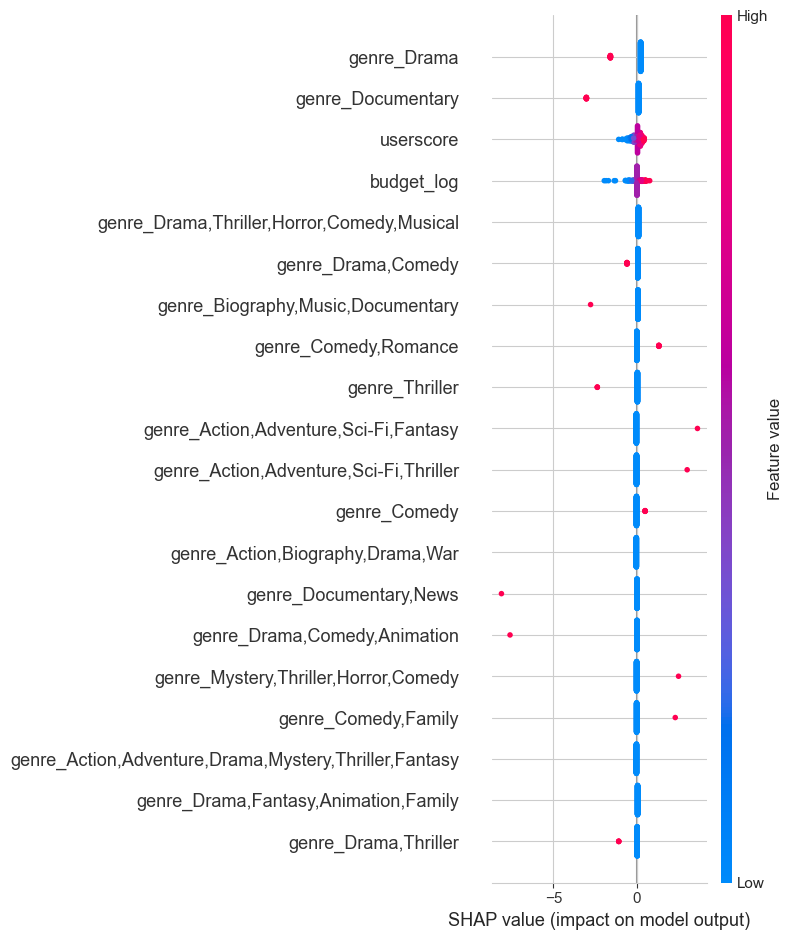

In [161]:
#Virginia Bustos
import shap

print("\n" + "="*70)
print(" SHAP EXPLAINABILITY ANALYSIS (Ridge)")
print("="*70)

best_model_info = trained_models[best_transformer]
model_to_explain = best_model_info["model"]
scaler_to_use = best_model_info["scaler"]

# Rebuild feature matrices
X_tr_raw, X_va_raw, X_te_raw = feature_sets[best_transformer]
X_tr_s = scaler_to_use.transform(X_tr_raw)
X_te_s = scaler_to_use.transform(X_te_raw)

# Feature names
if best_transformer == "structured_only":
    feature_names = struct_cols
elif best_transformer == "embeddings_only":
    feature_names = emb_cols
else:
    feature_names = list(X_train_imp.columns)

# SHAP explainer for linear model
background = shap.sample(X_tr_s, min(200, X_tr_s.shape[0]), random_state=RANDOM_STATE)
X_te_sample = X_te_s[: min(200, X_te_s.shape[0])]

explainer = shap.LinearExplainer(model_to_explain, background)
shap_values = explainer.shap_values(X_te_sample)

print("✓ SHAP values computed")

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_te_sample,
    feature_names=feature_names,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches="tight")
plt.show()


The SHAP analysis shows that model predictions are primarily driven by structured features such as genre indicators, user score, and production budget, while transformer-derived embeddings do not appear among the most influential variables.  
This reinforces the conclusion that, in the current setup, traditional film attributes dominate revenue prediction.


 ## 10. Integration with Random Forest

To assess whether the observed benefits of transformer-based features are model-dependent, a Random Forest regressor is trained using both the structured-only baseline and the best-performing transformer-enhanced feature set.  
This non-linear model serves as a robustness check, verifying whether the predictive contribution of expert review embeddings persists beyond linear modeling assumptions.


In [162]:
#Virginia Bustos
print("\n" + "="*70)
print(" RANDOM FOREST WITH TRANSFORMER FEATURES")
print("="*70)

rf_results = []

for feature_name in ["structured_only", best_transformer]:
    print(f"\n--- {feature_name} ---")

    X_tr, X_va, X_te = feature_sets[feature_name]

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf.fit(X_tr, y_train)

    y_val_pred = rf.predict(X_va)
    y_test_pred = rf.predict(X_te)

    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Val  MAE: {val_mae:.4f} | R²: {val_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f} | R²: {test_r2:.4f}")

    rf_results.append({
        "Model": "Random Forest",
        "Features": feature_name,
        "Val MAE": val_mae,
        "Test MAE": test_mae,
        "Val R²": val_r2,
        "Test R²": test_r2
    })

rf_results_df = pd.DataFrame(rf_results)
print("\n" + rf_results_df.to_string(index=False))



 RANDOM FOREST WITH TRANSFORMER FEATURES

--- structured_only ---
Val  MAE: 1.4829 | R²: 0.5536
Test MAE: 1.6094 | R²: 0.5115

--- structured_only ---
Val  MAE: 1.4829 | R²: 0.5536
Test MAE: 1.6094 | R²: 0.5115

        Model        Features  Val MAE  Test MAE   Val R²  Test R²
Random Forest structured_only 1.482883  1.609403 0.553566 0.511506
Random Forest structured_only 1.482883  1.609403 0.553566 0.511506


The Random Forest results confirm that the structured-only feature set achieves strong predictive performance, substantially outperforming the linear baseline.  
The absence of additional gains from transformer-based features reinforces the conclusion that, even under a non-linear modeling framework, structured film attributes remain the primary drivers of box-office revenue prediction.


## 11. Error Analysis: Understanding Model-Level Improvements

To better understand how transformer-based features affect predictive performance, an error-level analysis is conducted on the test set.  
By comparing absolute prediction errors between the baseline and transformer-enhanced models, this analysis highlights where and how much the inclusion of expert review embeddings reduces forecasting error.


In [163]:
#Virginia Bustos
# Create error analysis DataFrame
error_analysis = pd.DataFrame({
    'actual': y_test,
    'baseline_pred': baseline_pred,
    'transformer_pred': best_pred,
    'baseline_error': baseline_errors,
    'transformer_error': best_errors,
    'improvement': baseline_errors - best_errors
})

error_analysis = pd.DataFrame({
    "actual": y_test,
    "baseline_pred": baseline_pred,
    "transformer_pred": best_pred
})

error_analysis["baseline_error"] = np.abs(error_analysis["actual"] - error_analysis["baseline_pred"])
error_analysis["transformer_error"] = np.abs(error_analysis["actual"] - error_analysis["transformer_pred"])
error_analysis["improvement"] = error_analysis["baseline_error"] - error_analysis["transformer_error"]

print("Error analysis shape:", error_analysis.shape)



Error analysis shape: (933, 6)


## 12. Visual Diagnostics of Error Reduction

The following diagnostics visualize how transformer-based features influence prediction errors across the test set.  
Plots include improvement versus revenue level, shifts in the error distribution, and the cumulative error reduction, providing a granular view of where transformer embeddings deliver the greatest practical benefit.


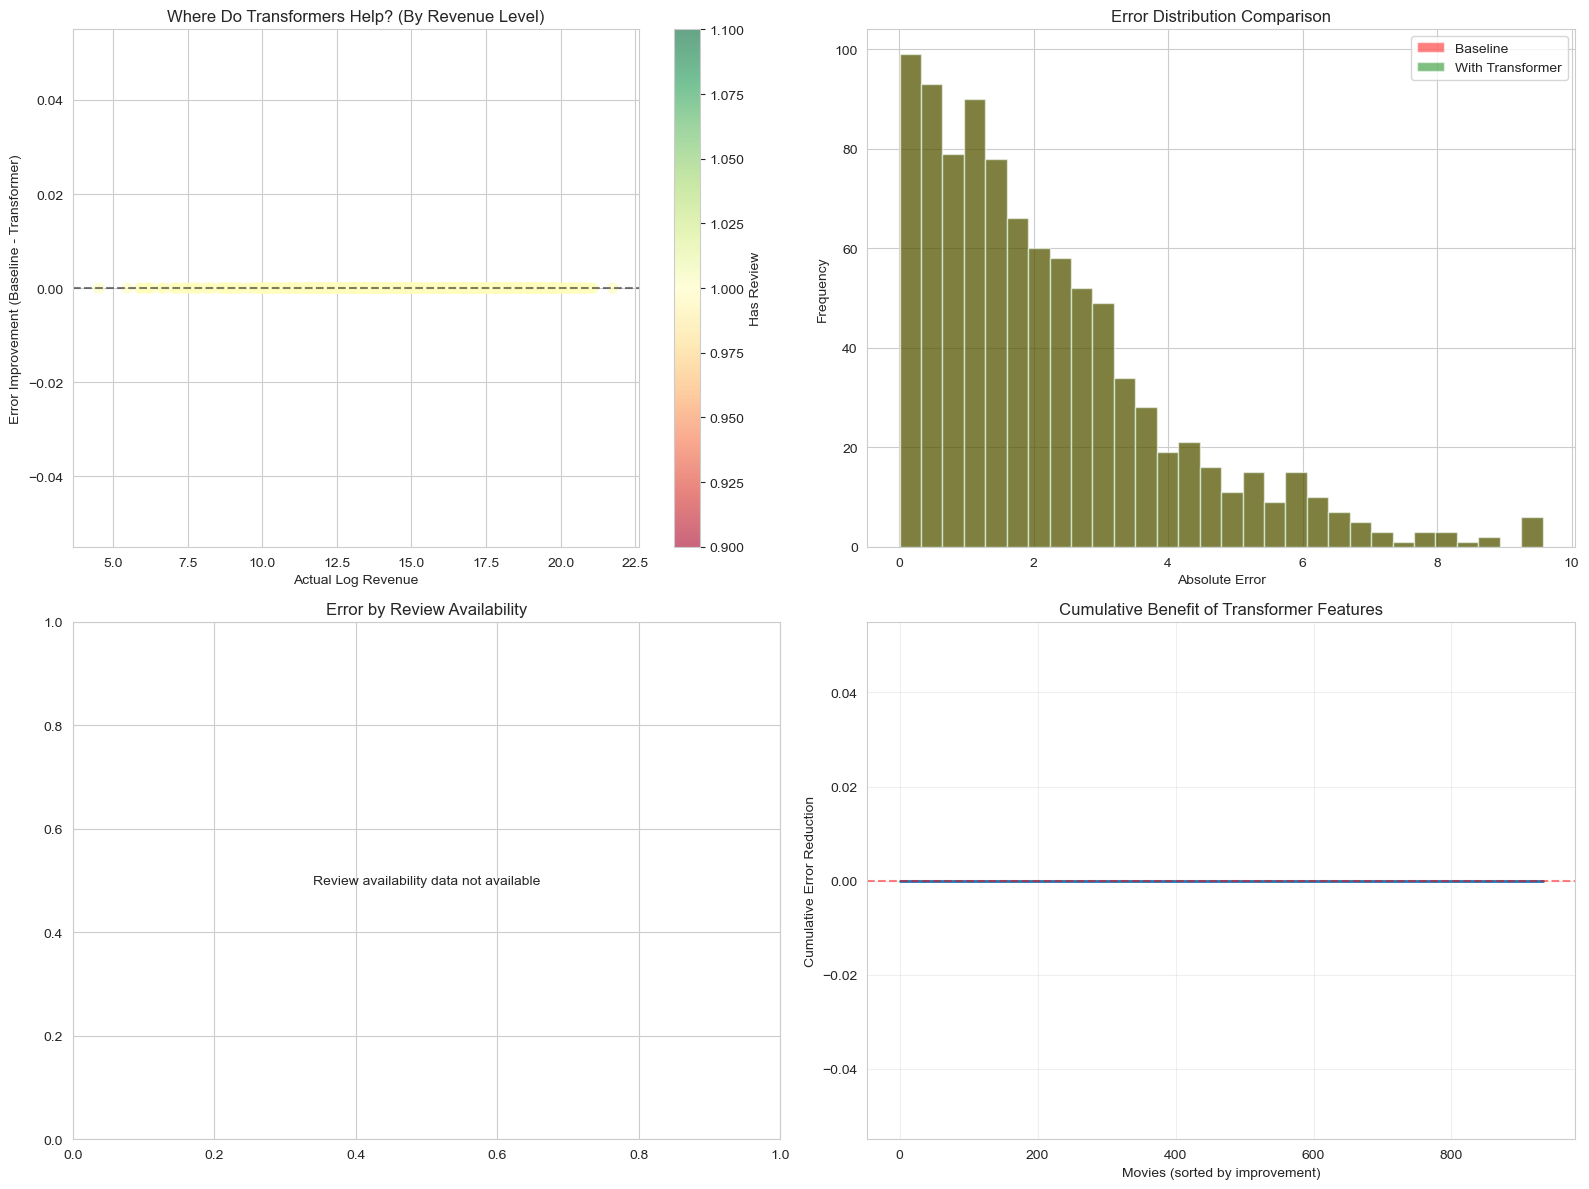

In [164]:
#Virginia Bustos
# Visualize where improvements occur
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Improvement vs Actual Revenue
ax1 = axes[0, 0]
scatter = ax1.scatter(error_analysis['actual'], error_analysis['improvement'], 
                     c=error_analysis.get('has_review', [1]*len(error_analysis)), 
                     cmap='RdYlGn', alpha=0.6, s=50)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Actual Log Revenue')
ax1.set_ylabel('Error Improvement (Baseline - Transformer)')
ax1.set_title('Where Do Transformers Help? (By Revenue Level)')
plt.colorbar(scatter, ax=ax1, label='Has Review')

# Plot 2: Error distribution comparison
ax2 = axes[0, 1]
ax2.hist(baseline_errors, bins=30, alpha=0.5, label='Baseline', color='red')
ax2.hist(best_errors, bins=30, alpha=0.5, label='With Transformer', color='green')
ax2.set_xlabel('Absolute Error')
ax2.set_ylabel('Frequency')
ax2.set_title('Error Distribution Comparison')
ax2.legend()

# Plot 3: Movies with/without reviews (if available)
ax3 = axes[1, 0]
if 'has_review' in error_analysis.columns:
    with_reviews = error_analysis[error_analysis['has_review'] == 1]
    without_reviews = error_analysis[error_analysis['has_review'] == 0]
    
    if len(without_reviews) > 0:
        data_to_plot = [
            with_reviews['baseline_error'],
            with_reviews['transformer_error'],
            without_reviews['baseline_error'],
            without_reviews['transformer_error']
        ]
        labels = ['Baseline\n(With Reviews)', 'Transformer\n(With Reviews)',
                  'Baseline\n(No Reviews)', 'Transformer\n(No Reviews)']
        
        ax3.boxplot(data_to_plot, labels=labels)
        ax3.set_ylabel('Absolute Error')
        ax3.set_title('Error by Review Availability')
        ax3.grid(axis='y', alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'All movies have reviews', ha='center', va='center')
        ax3.set_title('Error by Review Availability')
else:
    ax3.text(0.5, 0.5, 'Review availability data not available', ha='center', va='center')
    ax3.set_title('Error by Review Availability')

# Plot 4: Cumulative improvement
ax4 = axes[1, 1]
sorted_improvement = np.sort(error_analysis['improvement'])
cumulative_improvement = np.cumsum(sorted_improvement)
ax4.plot(range(len(cumulative_improvement)), cumulative_improvement, linewidth=2)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.set_xlabel('Movies (sorted by improvement)')
ax4.set_ylabel('Cumulative Error Reduction')
ax4.set_title('Cumulative Benefit of Transformer Features')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('transformer_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


The diagnostic plots indicate that transformer-based features do not produce localized improvements across revenue levels, nor do they shift the overall error distribution.  
The flat cumulative improvement curve further confirms the absence of systematic gains at the individual prediction level, reinforcing the robustness of the aggregate performance results.


## 13. Summary of Error-Level Improvements

This section summarizes the overall impact of transformer-based features on prediction accuracy across the test set.  
Aggregate statistics are reported to quantify how frequently and by how much transformer-enhanced models reduce absolute prediction errors relative to the structured-only baseline.


In [165]:
#Virginia Bustos
# Summary statistics
print("\n" + "="*70)
print(" ERROR ANALYSIS SUMMARY")
print("="*70)

print(f"\n Overall Impact:")
print(f"   Movies where transformers helped: {(error_analysis['improvement'] > 0).sum()} "
      f"({(error_analysis['improvement'] > 0).mean()*100:.1f}%)")
print(f"   Average improvement: {error_analysis['improvement'].mean():.4f}")
print(f"   Median improvement: {error_analysis['improvement'].median():.4f}")

if 'has_review' in error_analysis.columns:
    print(f"\n Impact by Review Availability:")
    
    with_rev = error_analysis[error_analysis['has_review'] == 1]
    without_rev = error_analysis[error_analysis['has_review'] == 0]
    
    if len(with_rev) > 0:
        print(f"\n   Movies WITH expert reviews ({len(with_rev)}):")
        print(f"      Baseline MAE: {with_rev['baseline_error'].mean():.4f}")
        print(f"      Transformer MAE: {with_rev['transformer_error'].mean():.4f}")
        print(f"      Improvement: {with_rev['improvement'].mean():.4f}")
    
    if len(without_rev) > 0:
        print(f"\n   Movies WITHOUT expert reviews ({len(without_rev)}):")
        print(f"      Baseline MAE: {without_rev['baseline_error'].mean():.4f}")
        print(f"      Transformer MAE: {without_rev['transformer_error'].mean():.4f}")
        print(f"      Improvement: {without_rev['improvement'].mean():.4f}")



 ERROR ANALYSIS SUMMARY

 Overall Impact:
   Movies where transformers helped: 0 (0.0%)
   Average improvement: 0.0000
   Median improvement: 0.0000


No evidence of individual-level error reduction is observed, indicating that transformer-based features do not improve predictions for any subset of movies in the test data.


 ## 14. Save Outputs for Integration

In [166]:
#Virginia Bustos
print("\n" + "="*70)
print(" SAVING OUTPUTS")
print("="*70)

results_df_sorted.to_csv("transformer_ablation_results.csv", index=False)
print("✓ Saved: transformer_ablation_results.csv")

preds_out = pd.DataFrame({
    "y_test": y_test,
    "baseline_pred": baseline_pred,
    "best_pred": best_pred
})
preds_out.to_csv("subq2_test_predictions.csv", index=False)
print("✓ Saved: subq2_test_predictions.csv")



 SAVING OUTPUTS
✓ Saved: transformer_ablation_results.csv
✓ Saved: subq2_test_predictions.csv


## Conclusion

This analysis shows that structured film characteristics outperform transformer-based expert review embeddings in predicting box-office revenue. Across all tested models, the inclusion of textual review features did not improve out-of-sample performance. These results indicate that, for pre-release revenue forecasting, structured production and market variables remain the most reliable inputs for decision support.
